<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(hop_skip_jump_white-box.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### HopSkipJumpAttack with ART: White-box

### Lab Objectives:   
- Understanding of HopSkipJumpAttack      
- Use Adversarial Robustness Toolkit (ART) to perform HopSkipJumpAttack  
- Perform the HopSkipJumpAttack when you have the model file (white-box)     
- Leverage mlflow    

**Keep the MLflow infrastructure running at the end. The other two labs are dependent on this infrastructure**  


### Step 1:  

In [1]:
# Import some libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

import mlflow
from mlflow.models import infer_signature

# Get the ART libraries  
import art
from art.attacks.evasion import HopSkipJump
from art.estimators.classification import PyTorchClassifier

import numpy as np

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Torchvision version used:  {torchvision.__version__}')
print(f'ART version used:  {art.__version__}')
print(f'Numpy version used:  {np.__version__}')
print(f'MLflow version used:  {mlflow.__version__}')

Torch version used:  2.7.1+cu128
Torchvision version used:  0.22.1+cu128
ART version used:  1.20.1
Numpy version used:  2.1.3
MLflow version used:  3.1.1


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# Setup a transform for the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

# Get the train and test data from MNIST
train_dataset = datasets.MNIST(root=r'/tmp/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=r'/tmp/', train=False, transform=transform)

In [5]:
# Setup a train loader
batch_size=64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1_000, shuffle=True)

In [6]:
# Get a bach of the data
X_sample, y_sample = next(iter(train_loader))
X_sample.shape, y_sample.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [7]:
# What does y look like
y_sample[:5]

tensor([2, 7, 4, 7, 5])

In [8]:
# Extract the test data
X_test, y_test = next(iter(test_loader))
X_test.shape, y_test.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

In [9]:
# Get the min and max value
X_test.min(), X_test.max()

(tensor(0.), tensor(1.))

### Start the mlflow server    
~$ **mlflow server --host 127.0.0.1 --port 9999**      
[2025-06-22 10:59:45 -0400] [191683] [INFO] Starting gunicorn 23.0.0  
[2025-06-22 10:59:45 -0400] [191683] [INFO] Listening at: http://127.0.0.1:9999 (191683)   
[2025-06-22 10:59:45 -0400] [191683] [INFO] Using worker: sync   

With the server running, open your browser and go to: http://127.0.0.1:9999     

In [10]:
# Setup the mlflow tracking server 
# mlflow requires us to have a tracking URL
tracking_uri = 'http://127.0.0.1:9999'
mlflow.set_tracking_uri(uri=tracking_uri)

# Create an experiment
# We name our experiment HopSkipJumpAttack   
mlflow.set_experiment(experiment_name='HopSkipJumpAttack')

<Experiment: artifact_location='mlflow-artifacts:/118242476423976612', creation_time=1752378317737, experiment_id='118242476423976612', last_update_time=1752378317737, lifecycle_stage='active', name='HopSkipJumpAttack', tags={}>

Get some data to use with our simple model.  Remember, neither the data or network is important here. The only thing that matters is our ability to attack the model. We are also building the model, so we can see everything from scratch.  

In [ ]:
# Set the random number generator for reproducibility 
torch.random.manual_seed(10)

# Create a simple model 
# Nothing exciting about our architecture 
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1, bias=False),
    nn.MaxPool2d(kernel_size=(3,3), stride=1, padding=1),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(3,3), stride=1, padding=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=50176, out_features=1024),
    nn.Linear(in_features=1024, out_features=10)
    #nn.Softmax(dim=-1)
)

# Move the model to the device
model = model.to(device=device)
model(X_sample.to(device))[:5]

tensor([[-0.0072, -0.0310, -0.0320,  0.0058, -0.0486, -0.0304, -0.0065, -0.0228,
          0.0595, -0.0317],
        [-0.0210, -0.0867, -0.0217,  0.0462, -0.0582, -0.0198,  0.0008, -0.0172,
          0.0002, -0.0585],
        [-0.0164, -0.0377, -0.0165,  0.0373, -0.0787, -0.0454, -0.0119, -0.0077,
          0.0397, -0.0525],
        [-0.0125, -0.0473, -0.0116,  0.0150, -0.0491, -0.0363,  0.0262,  0.0115,
         -0.0043, -0.0720],
        [-0.0306, -0.0666, -0.0344, -0.0042, -0.0191, -0.0371, -0.0366, -0.0237,
          0.0482, -0.0292]], device='cuda:0', grad_fn=<SliceBackward0>)

In [13]:
# Let us get the predictions
model(X_sample.to(device)).argmax(dim=-1)

tensor([8, 3, 8, 6, 8, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 6, 8, 8, 3, 8, 6, 8, 3, 8,
        8, 3, 3, 7, 8, 3, 6, 3, 3, 8, 3, 8, 3, 3, 3, 6, 8, 3, 8, 3, 8, 3, 3, 3,
        8, 8, 3, 3, 3, 3, 8, 8, 8, 6, 3, 3, 3, 3, 6, 3], device='cuda:0')

In [15]:
X_sample.device

device(type='cpu')

In [19]:
# Define an epoch
epoch = 5

# Setup a loss function
loss_fn = torch.nn.CrossEntropyLoss ()

# Setup the optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

# Wrap the training loop inside of mlflow context manager
with mlflow.start_run(run_name='final_run') as final_run:
    # Setup a model signature for the input and output of the model
    signature = infer_signature(model_input=X_sample.numpy(), model_output=model(X_sample.to(device)).detach().cpu().numpy()) 
    
    # Log the learning rate
    mlflow.log_param('lr', 0.1)

    # Run our training loop
    for i in range(epoch):
        for X, y in tqdm(train_loader, desc=f'Epoch: {i+1}/{epoch}'):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            
    print('Training completed!')

    # Just looking at the test accuracy. 
    # Training accuracy is not important for the problem we are solving
    test_logits = model(X_test.to(device))
    test_accuracy = sum(test_logits.detach().cpu().argmax(dim=-1) == y_test) / y_test.shape[0]
    print(f'Test accuracy: {test_accuracy}')

    mlflow.log_metric('test_accuracy', test_accuracy)
    model_info = mlflow.pytorch.log_model(pytorch_model=torch.jit.script(model), name='mnist_model', signature=signature, registered_model_name='mnist_registered_model')
    
    model_uri = f'runs:/{final_run.info.run_id}/mnist_model'

    print(f'Model saved in run {final_run.info.run_id}')
    print(f'Model URL: {model_uri}')
    
mlflow.end_run()

Epoch: 5/5: 100%|██████████| 938/938 [00:32<00:00, 29.14it/s] 


Training completed!
Test accuracy: 0.9539999961853027


2025/08/01 23:17:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 23:17:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'mnist_registered_model' already exists. Creating a new version of this model...
2025/08/01 23:17:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mnist

Model saved in run 8027d3d03137407f83dc10f53cb02fce
Model URL: runs:/8027d3d03137407f83dc10f53cb02fce/mnist_model
🏃 View run final_run at: http://127.0.0.1:9999/#/experiments/118242476423976612/runs/8027d3d03137407f83dc10f53cb02fce
🧪 View experiment at: http://127.0.0.1:9999/#/experiments/118242476423976612


Created version '2' of model 'mnist_registered_model'.


In [22]:
# Test the trained model's accuracy
test_logits = model(X_test.to(device))
test_accuracy = sum(test_logits.detach().cpu().argmax(dim=-1) == y_test) / y_test.shape[0]
test_accuracy

tensor(0.9540)

In [23]:
# Save the model
# We can save in either approach
torch.save(model.state_dict(), '/tmp/model.pth')
torch.jit.script(model).save(f='/tmp/model.jit')

### Step 2:  
With the model saved, we can now grab the model URI.  

**Note:** You are more likely to get a different value for your models URI than I have above. Please replace the URI with that below.   

In [24]:
# Getting the model URI
model_uri = model_info.model_uri
print(f'The Model URI is: {model_uri}')

The Model URI is: models:/m-2560fbf839e3419f8eee1e5a8aebc7b5


Split your terminal window if you can into two halves. This allows you to run things side-by-side so you can see everything within one screen.   

*Set environment variable*    
Before moving on, open another terminal and export the mlflow tracking URI
$ **export MLFLOW_TRACKING_URI=http://localhost:9999**    

You can then verify the variable is et:   
$ **env | grep MLFLOW**   
MLFLOW_TRACKING_URI=http://localhost:9999

*Load up the inference interface*    
**Note:** You are more likely to get a different value for your models URI than I have above. Please replace the URI with that below.  
$ **mlflow models serve --model-uri models:/m-bccb3b44d33c44349ea980b9fd975766 --port 5000 --no-conda**   
....    
INFO:     Started server process [192157]    
INFO:     Waiting for application startup.    
INFO:     Application startup complete.    
INFO:     Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)     


### Step 3: 

In [25]:
# Get the model
# This will work but throws an error about torch.jit.load
# This is because we save the model above via torch.jit.script(model)
# Not a problem, we get our predictions.  
loaded_model = mlflow.pyfunc.load_model(model_uri=model_uri)
loaded_model.predict(X_test.numpy()[:5])

/home/securitynik/miniconda3/envs/adversarial_ai/lib/python3.12/site-packages/torch/serialization.py:1488: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


array([[ 1.4330867e+08, -7.3795824e+07,  5.5985845e+06, -9.3815560e+07,
        -9.9743872e+07, -2.0231716e+07,  5.1758175e+06, -5.3083552e+07,
         9.5131470e+06, -3.5361936e+07],
       [-7.7427576e+07,  2.7723958e+07,  1.1101824e+08, -3.4468980e+07,
        -4.9028880e+07, -1.2028488e+08, -1.3567206e+08,  3.7724292e+07,
         6.3831540e+06, -3.0080378e+07],
       [-1.9049606e+07, -7.7796016e+07, -6.4887908e+07, -2.4867106e+07,
        -7.9246320e+07,  9.8317048e+07, -3.6657536e+07, -7.0054552e+07,
        -2.2677350e+07, -3.3195714e+07],
       [-1.5234531e+08, -1.2606442e+08, -7.3199576e+07,  1.0584658e+08,
        -1.5190426e+08, -1.5963080e+07, -2.3739141e+08, -4.1452616e+07,
        -3.1128140e+07, -3.7700292e+07],
       [-6.4920584e+07, -6.7215512e+07, -3.5828904e+07, -1.0997389e+07,
         8.7548656e+07, -3.6595648e+06, -1.0949787e+08,  6.8353376e+07,
         2.0529970e+07,  9.6061064e+07]], dtype=float32)

In [26]:
# Let us try to remove that warning
# First let's find where the model is saved
local_model_path = mlflow.artifacts.download_artifacts(artifact_uri=model_uri)
print(f'The local model path is: {local_model_path}')

# Now that we have the directory 
# If we list the directory we see 

!ls {local_model_path}. 

The local model path is: /tmp/tmpb0rnssuk/
MLmodel     data	     registered_model_meta
conda.yaml  python_env.yaml  requirements.txt


In [27]:
# Notice teh data folder above?
# This is where our model is stored  
# Prepended the data directory at the end of our path
# Also note, the model file is model.pth
!ls {local_model_path}/data

model.pth  pickle_module_info.txt


In [28]:
# Load the model finally
loaded_model = torch.jit.load(f=f'{local_model_path}/data/model.pth')
loaded_model

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Conv2d)
  (1): RecursiveScriptModule(original_name=MaxPool2d)
  (2): RecursiveScriptModule(original_name=Conv2d)
  (3): RecursiveScriptModule(original_name=MaxPool2d)
  (4): RecursiveScriptModule(original_name=Flatten)
  (5): RecursiveScriptModule(original_name=Linear)
  (6): RecursiveScriptModule(original_name=Linear)
)

In [31]:
# With our final model, make some predictions
loaded_model(X_test.to(device)[:5]).argmax(dim=-1)

tensor([0, 2, 5, 3, 9], device='cuda:0')

### Step 4:  
Now that we know this works, let us, let us use this model via a white-box approach for the HopSkipJump Attack    

Note: **Unfortunately, when I tried to build the ART classifier I started running into error. These errors are being left here for you to see the problem and recognize, building these solutions are not always simply plug and play but requires testing. More importantly, I am leaving the errors here for us to learn from them.**

For some strange reason, ART was seeing float64 values.    
Here is an error """ RuntimeError: expected scalar type Double but found Float """    

While most of the data seems to be float32, somehow, parts of the data seems to be flaot64 ...
"""   
[DEBUG] input dtype: torch.float32   
[DEBUG] input dtype: torch.float32   
....   
[DEBUG] input dtype: torch.float32   
[DEBUG] input dtype: torch.float64    
 
"""   

Notice the sudden change to float64. I am not sure why this was the case. However, this code below, helped me to detect this.   

Notice below, the wrapped_model is not set as model. You would need to make this change further below.    
art_white_box_clf = PyTorchClassifier(   
    model=wrapped_model,    
    loss=torch.nn.CrossEntropyLoss(),    
    optimizer=torch.optim.Adam(params=wrapped_model.parameters(), lr=0.1),    
    clip_values=(0., 1.),    
    nb_classes=10,    
    input_shape=X_test.shape[1:],    
    device_type=device    
)

In [32]:
# I was having problem with the model
class DebugModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        print(f'[DEBUG] input dtype: {x.dtype}')
        return self.model(x)

In [33]:
# Setup the wrapped model for debugging 
wrapped_model = DebugModel(model=loaded_model)
wrapped_model

DebugModel(
  (model): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=MaxPool2d)
    (2): RecursiveScriptModule(original_name=Conv2d)
    (3): RecursiveScriptModule(original_name=MaxPool2d)
    (4): RecursiveScriptModule(original_name=Flatten)
    (5): RecursiveScriptModule(original_name=Linear)
    (6): RecursiveScriptModule(original_name=Linear)
  )
)

In [34]:
# Setup the classifier 
art_white_box_clf = PyTorchClassifier(
    model= wrapped_model,    # Notice the wrapped model here. This is for debugging below.
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=wrapped_model.parameters(), lr=0.1),
    clip_values=(0., 1.), 
    nb_classes=10, 
    input_shape=X_test.shape[1:], 
    device_type=device
)


In [35]:
# Create the HopSkipJumpAttack  
art_attack_white_box = HopSkipJump(classifier=art_white_box_clf, 
                                   targeted=False, 
                                   norm=2, 
                                   max_iter=10,     # Increase this should improve the attack
                                   max_eval=1000,   # Same here
                                   verbose=True)

art_attack_white_box

HopSkipJump(targeted=False, norm=2, max_iter=10, max_eval=1000, init_eval=100, init_size=100, curr_iter=0, batch_size=64, verbose=True, )

In [36]:
# Generate the adversarial examples
# This will generate an error
X_adv_examples = art_attack_white_box.generate(x=X_test.numpy(), y=None)

[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float32
[DEBUG] input dtype:

HopSkipJump:   0%|          | 0/1000 [00:00<?, ?it/s]

[DEBUG] input dtype: torch.float32
[DEBUG] input dtype: torch.float64


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/torch/nn/modules/container.py", line 22, in forward
    _5 = getattr(self, "5")
    _6 = getattr(self, "6")
    input0 = (_0).forward(input, )
              ~~~~~~~~~~~ <--- HERE
    input1 = (_1).forward(input0, )
    input2 = (_2).forward(input1, )
  File "code/__torch__/torch/nn/modules/conv.py", line 23, in forward
    weight = self.weight
    bias = self.bias
    _0 = (self)._conv_forward(input, weight, bias, )
          ~~~~~~~~~~~~~~~~~~~ <--- HERE
    return _0
  def _conv_forward(self: __torch__.torch.nn.modules.conv.Conv2d,
  File "code/__torch__/torch/nn/modules/conv.py", line 29, in _conv_forward
    weight: Tensor,
    bias: Optional[Tensor]) -> Tensor:
    _1 = torch.conv2d(input, weight, bias, [1, 1], [1, 1], [1, 1])
         ~~~~~~~~~~~~ <--- HERE
    return _1

Traceback of TorchScript, original code (most recent call last):
  File "/home/securitynik/miniconda3/envs/adversarial_ai/lib/python3.12/site-packages/torch/nn/modules/container.py", line 240, in forward
    def forward(self, input):
        for module in self:
            input = module(input)
                    ~~~~~~ <--- HERE
        return input
  File "/home/securitynik/miniconda3/envs/adversarial_ai/lib/python3.12/site-packages/torch/nn/modules/conv.py", line 554, in forward
    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)
               ~~~~~~~~~~~~~~~~~~ <--- HERE
  File "/home/securitynik/miniconda3/envs/adversarial_ai/lib/python3.12/site-packages/torch/nn/modules/conv.py", line 549, in _conv_forward
                self.groups,
            )
        return F.conv2d(
               ~~~~~~~~ <--- HERE
            input, weight, bias, self.stride, self.padding, self.dilation, self.groups
        )
RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same


Let us now fix the problem above. Above, we created a wrapper for the model to debug the issue. Now that we know what the issue is, let us create a wrapper to fix the issue.  


In [37]:
# Create a new wrapper class for the model
class FixedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        if x.dtype != torch.float32:
            x = x.float()
        return self.model(x)

In [38]:
# Instantiate the model for ART
art_safe_model = FixedModel(model=loaded_model).to(device)
art_safe_model

FixedModel(
  (model): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=MaxPool2d)
    (2): RecursiveScriptModule(original_name=Conv2d)
    (3): RecursiveScriptModule(original_name=MaxPool2d)
    (4): RecursiveScriptModule(original_name=Flatten)
    (5): RecursiveScriptModule(original_name=Linear)
    (6): RecursiveScriptModule(original_name=Linear)
  )
)

In [39]:
# Specify our model 
# loss function as CrossEntropy Loss
# Clip the output between -2 and 2
# The original input is between -4 and 4
# Set the input shape to the shape of X
art_white_box_clf = PyTorchClassifier(model=art_safe_model, 
                                      loss=torch.nn.CrossEntropyLoss(),
                                      optimizer=torch.optim.Adam(params=loaded_model.parameters(), lr=0.1),
                                      clip_values=(0., 1.), 
                                      nb_classes=10, 
                                      input_shape=X_test.shape[1:], 
                                      device_type=device)

art_white_box_clf

art.estimators.classification.pytorch.PyTorchClassifier(model=ModelWrapper(
  (_model): FixedModel(
    (model): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=MaxPool2d)
      (2): RecursiveScriptModule(original_name=Conv2d)
      (3): RecursiveScriptModule(original_name=MaxPool2d)
      (4): RecursiveScriptModule(original_name=Flatten)
      (5): RecursiveScriptModule(original_name=Linear)
      (6): RecursiveScriptModule(original_name=Linear)
    )
  )
), loss=CrossEntropyLoss(), optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
), input_shape=torch.Size([1, 28, 28]), nb_classes=10, channels_first=True, clip_values=array([0., 1.], dtype=float32), preprocessing_defences

In [40]:
# Create the HopSkipJumpAttack  
# https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#hopskipjump-attack
art_attack_white_box = HopSkipJump(classifier=art_white_box_clf, 
                                   targeted=False, 
                                   norm=2, 
                                   init_eval=2,
                                   max_iter=10,     # Increase this should improve the attack
                                   max_eval=100,   # Same here
                                   verbose=True)

art_attack_white_box

HopSkipJump(targeted=False, norm=2, max_iter=10, max_eval=100, init_eval=2, init_size=100, curr_iter=0, batch_size=64, verbose=True, )

I kept the max_iter=10 and max_eval=100 just to ensure the attack is fast in the interest of time. However, feel free to go ahead and increase these numbers. This should give you a better result.   

In [41]:
# Generate the adversarial examples
# As this is untargeted, we simply wishes to flip the class
X_adv_examples = art_attack_white_box.generate(x=X_test.numpy(), y=None)
X_adv_examples

HopSkipJump:   0%|          | 0/1000 [00:00<?, ?it/s]

array([[[[3.84954870e-01, 5.05443588e-02, 0.00000000e+00, ...,
          0.00000000e+00, 8.77843797e-03, 0.00000000e+00],
         [4.66915369e-02, 0.00000000e+00, 3.68113279e-01, ...,
          2.65739653e-02, 3.26582164e-01, 0.00000000e+00],
         [2.74273127e-01, 2.17970893e-01, 1.26707166e-01, ...,
          0.00000000e+00, 3.28005075e-01, 2.17819646e-01],
         ...,
         [1.86429154e-02, 2.15741485e-01, 2.01144323e-01, ...,
          3.97726417e-01, 1.28487036e-01, 4.01828326e-02],
         [0.00000000e+00, 1.29454195e-01, 1.22512385e-01, ...,
          2.10666940e-01, 1.55011609e-01, 1.31299570e-02],
         [4.23655778e-01, 2.80913413e-01, 2.10755900e-03, ...,
          1.73176572e-01, 2.60233283e-01, 2.10678130e-01]]],


       [[[1.28277063e-01, 7.09191114e-02, 2.26720069e-02, ...,
          1.69817694e-02, 3.48678619e-01, 4.64740284e-02],
         [1.33095399e-01, 1.90993294e-01, 0.00000000e+00, ...,
          2.51156956e-01, 2.40240544e-01, 2.00988397e-01],
      

In [42]:
# Make predictions with the adversarial examples
# Convert the adversarial examples to torch tensors
X_adv_examples = torch.as_tensor(data=X_adv_examples, dtype=torch.float32, device=device)
adv_preds = model(X_adv_examples).argmax(dim=-1)
adv_preds[:10]

tensor([1, 1, 1, 1, 4, 1, 1, 3, 2, 1], device='cuda:0')

In [44]:
# Calculate the adversarial success
# This is our ability to create adversarial samples that flipped the labels of the images
adversarial_success = (art_white_box_clf.predict(x=X_adv_examples.detach().cpu()).argmax(axis=-1) != y_test.numpy()).sum() / y_test.shape[0]

In [45]:
# With the training finish clear the GPU cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cuda cache


### Step 5:   
Visualize the result   

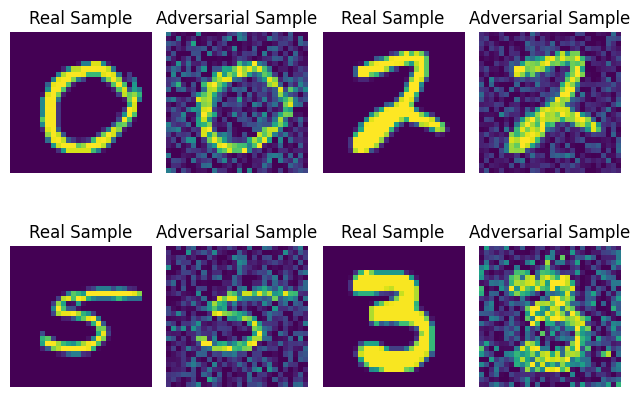

In [49]:
# Visualize the result of a few samples
plt.subplot(241)
plt.title('Real Sample')
plt.imshow(X_test[0].permute(dims=(1,2,0)))
plt.axis('off')

plt.subplot(242)
plt.title('Adversarial Sample')
plt.imshow(X_adv_examples[0].detach().cpu().permute(dims=(1,2,0)))
plt.axis('off')

plt.subplot(243)
plt.title('Real Sample')
plt.imshow(X_test[1].permute(dims=(1,2,0)))
plt.axis('off')

plt.subplot(244)
plt.title('Adversarial Sample')
plt.imshow(X_adv_examples[1].detach().cpu().permute(dims=(1,2,0)))
plt.axis('off')

plt.subplot(245)
plt.title('Real Sample')
plt.imshow(X_test[2].permute(dims=(1,2,0)))
plt.axis('off')

plt.subplot(246)
plt.title('Adversarial Sample')
plt.imshow(X_adv_examples[2].detach().cpu().permute(dims=(1,2,0)))
plt.axis('off')

plt.subplot(247)
plt.title('Real Sample')
plt.imshow(X_test[3].permute(dims=(1,2,0)))
plt.axis('off')

plt.subplot(248)
plt.title('Adversarial Sample')
plt.imshow(X_adv_examples[3].detach().cpu().permute(dims=(1,2,0)))
plt.axis('off')

plt.tight_layout()
plt.show()

In [51]:
# We can also confirm that the results of the samples are not the same
(X_test[:5] == X_adv_examples.detach().cpu()[:5]).all()

tensor(False)

### Takeaways:   
- We leverage HopSkipJumpAttack to create new adversarial samples
- In this lab, we had access to the model. 
- In the real world you may not have access to the model   
- We saw how we could mitigate this attack using our firewall. 

**Keep this lab running at the end. The other two labs are dependent on this infrastructure**  